# Relax Challenge

In [1]:
# import modules and libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_curve, auc

## 1. Exploring data

In [2]:
# Export csv files as dataframes
users = pd.read_csv('C:/Jupyter_Notebooks/relax_challenge/relax_challenge/takehome_users.csv', encoding='latin1')
user_engagement = pd.read_csv('takehome_user_engagement.csv')

In [3]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null object
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


Looks like we are missing some values for the last_session_creation_time and the invited_by_user.

In [4]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [5]:
user_engagement.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [6]:
user_engagement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
time_stamp    207917 non-null object
user_id       207917 non-null int64
visited       207917 non-null int64
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


We do have all in information we need for the user_engagement information. In order to determine and "adopted user" label, we need to find users who have logged into the product on 3 separate days during a 7 week period.

In [7]:
user_engagement.describe()

,user_id,visited
count,207917.000000,207917.0
mean,5913.314197,1.0
std,3394.941674,0.0
min,1.000000,1.0
25%,3087.000000,1.0
50%,5682.000000,1.0
75%,8944.000000,1.0
max,12000.000000,1.0


We see that visited always has a value of one so every row indicates a visit for a user. We can separate the rows by pulling out user_id and the times they visited, then resample the information by days, including counts of all visits for that day.

In [8]:
# Convert time stamp into Timeseries
user_engagement.time_stamp = pd.to_datetime(user_engagement.time_stamp)

# Group by user_ID, resampling timeseries data to single day for users
user_per_week = user_engagement.groupby(['user_id', pd.Grouper(key='time_stamp', freq="W")]).count().reset_index()

In [9]:
# Find adopted users
adopted_u = {}
for index in user_per_week.index:
    if user_per_week.visited[index] >=3:
        adopted_u[user_per_week.user_id[index]] = 1

# Turn adopted users dictionary into series
adopted_u = pd.Series(adopted_u)

In [10]:
# Set user_id as index for users dataframe
new_users = users.set_index('object_id')

# concatenate adopted users to users data
labeled_users = pd.concat([new_users, adopted_u], axis=1)

# Create account age column
labeled_users.creation_time = pd.to_datetime(labeled_users.creation_time)

converter = lambda x: datetime.utcfromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S')
labeled_users.last_session_creation_time = labeled_users.last_session_creation_time.map(converter, na_action='ignore')
labeled_users.last_session_creation_time = pd.to_datetime(labeled_users.last_session_creation_time)

labeled_users["account_age"] = labeled_users.last_session_creation_time - labeled_users.creation_time

In [11]:
# rename last column as adapted users
labeled_users = labeled_users.rename(columns={0:'adapted_users'})

In [12]:
labeled_users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 1 to 12000
Data columns (total 11 columns):
creation_time                 12000 non-null datetime64[ns]
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null datetime64[ns]
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
adapted_users                 1445 non-null float64
account_age                   8823 non-null timedelta64[ns]
dtypes: datetime64[ns](2), float64(2), int64(3), object(3), timedelta64[ns](1)
memory usage: 1.1+ MB


In [13]:
# Create final clean dataframe
clean_users = labeled_users.drop(['creation_time', 'name','email','last_session_creation_time'], axis=1)
clean_users = pd.get_dummies(clean_users)

# Convert timedelta64 data to float64
clean_users.account_age = clean_users.account_age / np.timedelta64(1, "D")

# Fill in NaN values
clean_users.fillna(0, inplace = True)

clean_users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 1 to 12000
Data columns (total 11 columns):
opted_in_to_mailing_list              12000 non-null int64
enabled_for_marketing_drip            12000 non-null int64
org_id                                12000 non-null int64
invited_by_user_id                    12000 non-null float64
adapted_users                         12000 non-null float64
account_age                           12000 non-null float64
creation_source_GUEST_INVITE          12000 non-null uint8
creation_source_ORG_INVITE            12000 non-null uint8
creation_source_PERSONAL_PROJECTS     12000 non-null uint8
creation_source_SIGNUP                12000 non-null uint8
creation_source_SIGNUP_GOOGLE_AUTH    12000 non-null uint8
dtypes: float64(3), int64(3), uint8(5)
memory usage: 714.8 KB


In [14]:
# Modelling to determine best model
y = clean_users.adapted_users
X = clean_users.drop('adapted_users', axis=1)

In [15]:
def train_model(x, y, model, params, test_size=0.2, random_state =42):
    
    # Split Training and testing data
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=random_state)
    
    model_cv = GridSearchCV(model, param_grid=params, cv=5, n_jobs=-1, verbose=10)
    
    model_cv.fit(X_train, y_train)
    
    y_pred = model_cv.predict(X_test)
    
    print(f'Best hyperparameters: {model_cv.best_params_}')
    print(classification_report(y_test, y_pred))

In [16]:
# Logistic regression model with classification report
lr = LogisticRegression()
lr_param_grid = {"C": [0.001, 0.01, 0.1, 1, 10, 100, 1000], "penalty": ['l1','l2'], "solver":['liblinear','saga']}
train_model(X,y,lr, lr_param_grid)

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    6.3s


Best hyperparameters: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      2108
         1.0       0.95      0.90      0.92       292

    accuracy                           0.98      2400
   macro avg       0.97      0.95      0.96      2400
weighted avg       0.98      0.98      0.98      2400



[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:    7.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:    7.2s finished


In [17]:
# SVC model with classification report
svc = SVC()
svc_param_grid = [{'C':[0.1, 1, 10, 100, 1000], 'kernel': ['linear']}]
train_model(X, y, svc, svc_param_grid)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  13 out of  25 | elapsed:  3.5min remaining:  3.3min
[Parallel(n_jobs=-1)]: Done  16 out of  25 | elapsed:  4.1min remaining:  2.3min
[Parallel(n_jobs=-1)]: Done  19 out of  25 | elapsed:  5.0min remaining:  1.6min
[Parallel(n_jobs=-1)]: Done  22 out of  25 | elapsed:  7.1min remaining:   57.6s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  9.5min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  9.5min finished


Best hyperparameters: {'C': 0.1, 'kernel': 'linear'}
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99      2108
         1.0       0.93      0.89      0.91       292

    accuracy                           0.98      2400
   macro avg       0.96      0.94      0.95      2400
weighted avg       0.98      0.98      0.98      2400



In [18]:
# Random Forest Classifier with Classification report
rf = RandomForestClassifier()
rf_param_grid = {
                 'n_estimators' : [10,50,100,200,500,1000],
                 'max_depth' : [3,None],
                 'min_samples_split' : [2,5,10],
                 'min_samples_leaf' : [1,2,3],
                 'bootstrap':[True, False]}
train_model(X,y,rf, rf_param_grid)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   19.7s
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:   21.3s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   25.2s
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:   28.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   

Best hyperparameters: {'bootstrap': False, 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      2108
         1.0       0.91      0.93      0.92       292

    accuracy                           0.98      2400
   macro avg       0.95      0.96      0.95      2400
weighted avg       0.98      0.98      0.98      2400



In [19]:
knn = KNeighborsClassifier()
n = list(range(1,9))
knn_param_grid = [{'n_neighbors':n}]
train_model(X,y,knn,knn_param_grid)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    1.0s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  35 out of  40 | elapsed:    1.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    1.2s finished


Best hyperparameters: {'n_neighbors': 3}
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99      2108
         1.0       0.95      0.84      0.89       292

    accuracy                           0.97      2400
   macro avg       0.96      0.91      0.94      2400
weighted avg       0.97      0.97      0.97      2400



Looking above, it seems the logistic regression may have performed the best. The accuracy score of the KNearestNeighbor classifier was the lowest, with 97%. The other models all scored 98% accuracy, but the logistic regression had the highest f1 score for the adopted user category. Let’s look closer at it and the coefficients it determined were more significant.

In [20]:
# Create the logistic regression model outside of the function to see coefficient significance
lr_model = LogisticRegression(C= 0.1, penalty= 'l1', solver= 'liblinear')

Xt_train, Xt_test, yt_train, yt_test = train_test_split(X, y, test_size=0.2, random_state=42)

lr_model.fit(Xt_train, yt_train)
yt_pred = lr_model.predict(Xt_test)

# Check that model is the same
print(classification_report(yt_test, yt_pred))

# Print list of coefficients. Positive values correlate to an addopted user, negative to a user who is not.
print(pd.DataFrame(lr_model.coef_.tolist()[0], index=list(X.columns), columns=["coef"]).sort_values(by="coef", ascending=False))

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      2108
         1.0       0.95      0.90      0.93       292

    accuracy                           0.98      2400
   macro avg       0.97      0.95      0.96      2400
weighted avg       0.98      0.98      0.98      2400

                                        coef
account_age                         0.049482
opted_in_to_mailing_list            0.000000
enabled_for_marketing_drip          0.000000
creation_source_GUEST_INVITE        0.000000
creation_source_ORG_INVITE          0.000000
creation_source_SIGNUP              0.000000
creation_source_SIGNUP_GOOGLE_AUTH  0.000000
invited_by_user_id                 -0.000028
org_id                             -0.000067
creation_source_PERSONAL_PROJECTS  -0.109701


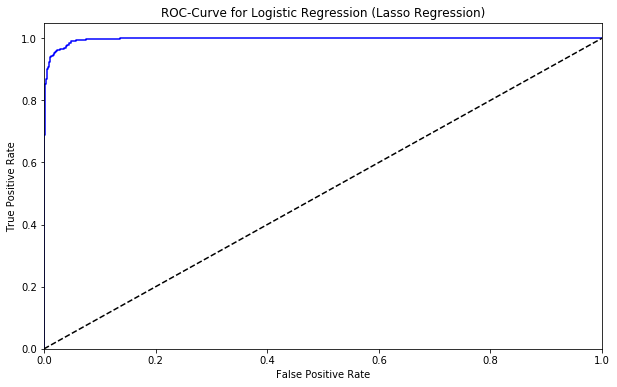

In [21]:
# Plot ROC-curve
yt_pred_prob = lr_model.predict_proba(Xt_test)[:,1]

fpr, tpr, thresholds = roc_curve(yt_test,yt_pred_prob)

roc_auc = auc(fpr, tpr)

plt.subplots(figsize=(10,6))
plt.plot(fpr, tpr,'b', label= 'AUC = %0.2f' %roc_auc)
plt.plot([0,1],[0,1], "k--")
plt.xlim([0,1])
plt.ylim([0,1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-Curve for Logistic Regression (Lasso Regression)")
plt.show()

Looking at the coefficients above, we can see that the most powerful feature for determining if someone is an adopted user is if the creation source was in the personal project category. This means the user was invited to join another user’s personal workspace, but this seems to be a negative feature. Following this, the account age seems to indicate more of a positive feature for being an adopted user.